In [22]:
import pandas as pd
import numpy as np
from os import listdir
from os.path import isfile, join, isdir
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [2]:
class KmeansVectorQuantizer():
    def __init__(self, size, strike, cluster):
        self.size = size
        self.strike = strike
        self.cluster = cluster
        self.kmeans = KMeans(n_clusters=cluster)
        self.bins = np.linspace(-0.5, cluster-0.5, cluster+1)
    
    # TODO assume input data is list of arrays, each array is one input sample, each sample with shape (dimension, length)
    # To generalize to different input data shape
    def sample_slice(self, sample):
        #### Args #########################
        # sample: single input sample, array with shape (dimension, length)
        #### Return #######################
        # array of new length = size * dimension, number of slices
        return np.array([sample[:,i*self.strike:i*self.strike+self.size].flatten() 
                         for i in range(int((sample.shape[1]-self.size)/self.strike))])
        
    def fit(self, data):
        # cut the input data into pieces of length size * input dimension
        sliced_data = [self.sample_slice(data[i]) for i in range(len(data))]
        # fit the kmeans 
        self.kmeans.fit(np.concatenate(sliced_data))
    
    def transform(self, data):
        # cut the input data into pieces of length size * input dimension
        sliced_data = [self.sample_slice(data[i]) for i in range(len(data))]
        # vector: list, each element of the list corresponds to one sample of input, contains the array of nearest kmeans cluster center index
        vectors = []
        for m in range(len(sliced_data)):
            # TODO use kmeans.predict() to find the nearest cluster center for sliced data
            vectors.append(np.array([np.argmin(np.array([np.linalg.norm(sliced_data[m][j]-self.kmeans.cluster_centers_[i]) 
                                                         for i in range(self.cluster)])) for j in range(sliced_data[m].shape[0])]))      
        # returns input with vector quantization transformation
        # array of shape: (number of samples in input, number of cluster)
        return np.array([np.histogram(vectors[i], self.bins)[0] for i in range(len(vectors))])        
        
    def fit_transform(self, data):
        sliced_data = [self.sample_slice(data[i]) for i in range(len(data))]
        self.kmeans.fit(np.concatenate(sliced_data))
        vectors = []
        for m in range(len(sliced_data)):
            # TODO use kmeans.predict() to find the nearest cluster center for sliced data
            vectors.append(np.array([np.argmin(np.array([np.linalg.norm(sliced_data[m][j]-self.kmeans.cluster_centers_[i]) 
                                                         for i in range(self.cluster)])) for j in range(sliced_data[m].shape[0])]))      
        return np.array([np.histogram(vectors[i], self.bins)[0] for i in range(len(vectors))])         

In [3]:
# Read in data
X = []
label = []

folders = [f for f in listdir('data') if isdir(join('data', f))]
for folder in folders:
    for file in listdir('data/'+folder):
        if isfile(join('data/'+folder, file)):
            data = pd.read_csv('data/'+folder+'/'+file, header=None, names =['x','y','z'], sep=' ') 
            X.append(np.array([data['x'].values, data['y'].values, data['z'].values]))
            label.append(folder)


# transformation from label string to class index            
le=LabelEncoder()
y = le.fit_transform(label)            

In [13]:
kf = KFold(n_splits=3, shuffle =True)
knn = KNeighborsClassifier (5)
rf = RandomForestClassifier(n_estimators=150, max_depth=20)


# Random initialization of hyper parameters
np.random.seed(3)
K = np.floor(10 ** np.random.uniform(low=1, high=2.5, size=5)).astype(int)
step = np.floor(10 ** np.random.uniform(low=1, high=2, size=5)).astype(int)
strike = np.floor(step * np.random.rand(5)).astype(int)
result = pd.DataFrame(data=np.zeros((5,5)), index=None, columns=['K','Step','Strike','NN_Acc','RF_Acc'], dtype=None, copy=False)
result[['K','Step','Strike']] = np.concatenate((K.reshape(5,1), step.reshape(5,1), strike.reshape(5,1)), axis=1)

# Experiment, to get best K, step, strike, and classifier
cnt = 0 
for (K, step, strike) in ([(K[i], step[i], strike[i]) for i in range(5)]):
    accuracy_nn = 0
    accuracy_rf = 0
    for train_index, test_index in kf.split(X):  
        vq = KmeansVectorQuantizer(step,strike,K)
        X_train = vq.fit_transform([X[i] for i in train_index])
        X_test = vq.transform([X[i] for i in test_index])

        knn.fit(X_train, y[train_index])
        accuracy_nn = accuracy_nn + 1/3*knn.score(X_test, y[test_index])

        rf.fit(X_train, y[train_index])
        accuracy_rf = accuracy_rf + 1/3*rf.score(X_test, y[test_index])

        
    result.NN_Acc.iloc[cnt]=accuracy_nn
    result.RF_Acc.iloc[cnt]=accuracy_rf
    cnt=cnt+1
        
        
    #print(train_index)
    

In [14]:
result

,K,Step,Strike,NN_Acc,RF_Acc
0,67.0,78.0,2.0,0.716351,0.797372
1,115.0,13.0,5.0,0.666231,0.809293
2,27.0,16.0,10.0,0.709221,0.762814
3,58.0,11.0,3.0,0.709174,0.781883
4,218.0,27.0,18.0,0.622167,0.760463


In [38]:
# Best transformation: K=115, step=13, strike=5
rf = RandomForestClassifier(n_estimators=150, max_depth=20)
kf = KFold(n_splits=3, shuffle =True)
vq = KmeansVectorQuantizer(13,5,115)
# average confusion matrix for K fold (K=3) under best chosen transformation
conf_mat = []
for train_index, test_index in kf.split(X):  
    X_train = vq.fit_transform([X[i] for i in train_index])
    X_test = vq.transform([X[i] for i in test_index])

    rf.fit(X_train, y[train_index])
    y_predict = rf.predict(X_test)
    conf_mat.append(confusion_matrix(le.inverse_transform(y[test_index]), le.inverse_transform(y_predict), le.classes_))


Confusion matrix, without normalization
[[ 3  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 37  0  0  1  0  0  0  0  1  0  0  2]
 [ 0  0  9  0  0  0  0  0  0  0  0  0  0]
 [ 0  5  0 13  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 26  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  2  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 28  0  1  0  9  0  0]
 [ 0  0  0  0  0  0  6  0  1  5  1  0  0]
 [ 0  0  0  0  1  0  0  0 28  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0 22  7  0  0]
 [ 0  0  0  0  0  0  0  0  0  5 34  0  0]
 [ 0  0  0  0  2  0  0  0  2  0  0  1  0]
 [ 0  4  0  0  0  0  0  0  0  2  1  0 19]]


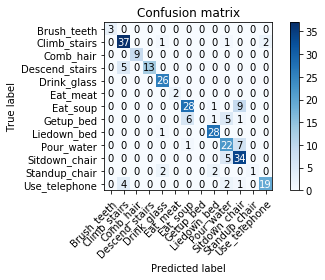

In [43]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(le.inverse_transform(y[test_index]), le.inverse_transform(y_predict), classes=le.classes_,
                      title='Confusion matrix')

plt.show()

No handles with labels found to put in legend.


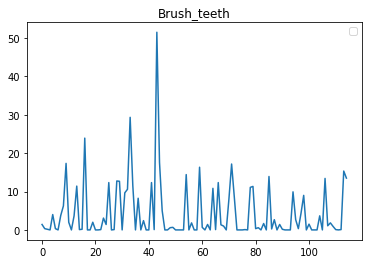

No handles with labels found to put in legend.


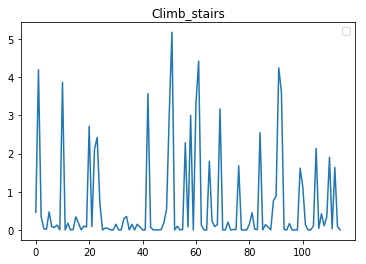

No handles with labels found to put in legend.


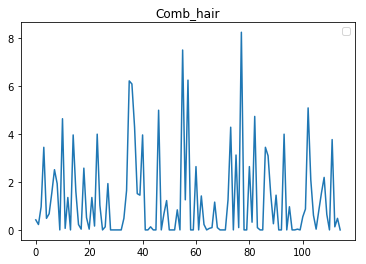

No handles with labels found to put in legend.


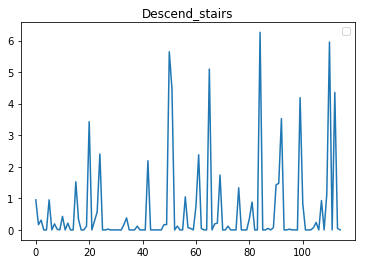

No handles with labels found to put in legend.


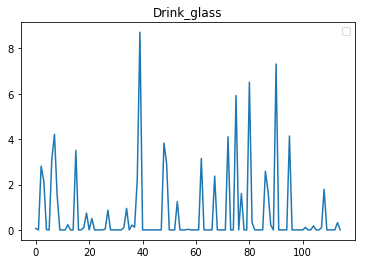

No handles with labels found to put in legend.


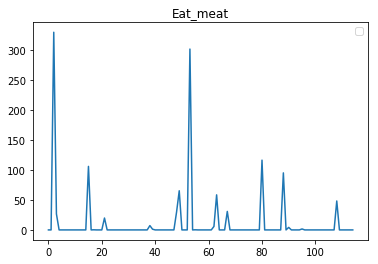

No handles with labels found to put in legend.


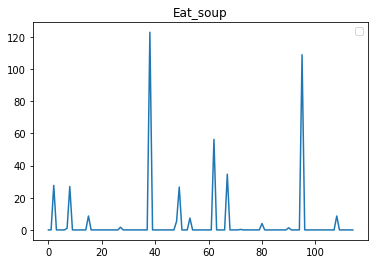

No handles with labels found to put in legend.


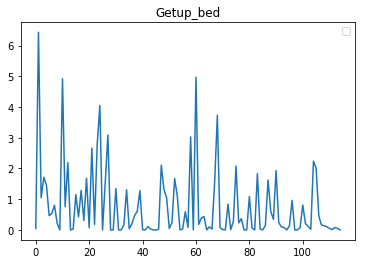

No handles with labels found to put in legend.


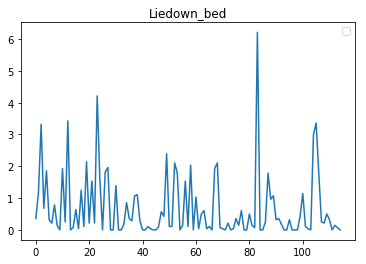

No handles with labels found to put in legend.


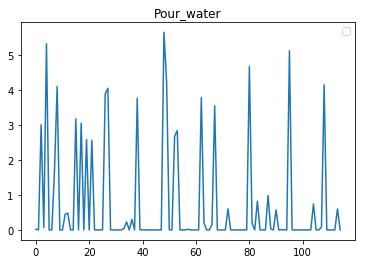

No handles with labels found to put in legend.


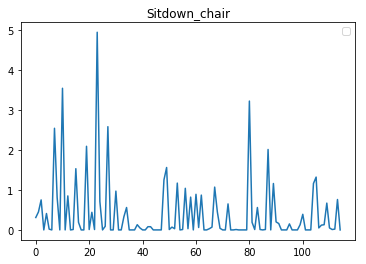

No handles with labels found to put in legend.


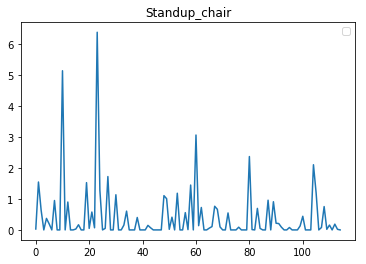

No handles with labels found to put in legend.


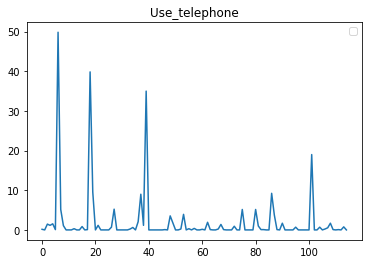

No handles with labels found to put in legend.


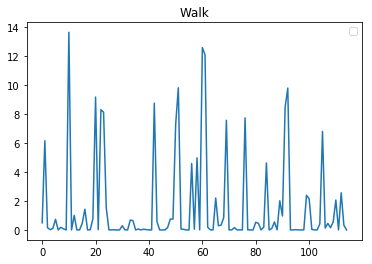

In [23]:
# Best transformation: K=115, step=13, strike=5
vq = KmeansVectorQuantizer(13,5,115)
X_transformed = vq.fit_transform(X)
# Histogram of mean quantized vector for each class
for l in le.classes_:
    fig = plt.figure()
    ax = plt.subplot(111)
    hist = np.mean(X_transformed[[i for i in range(len(label)) if label[i] == l]], axis=0)
    ax.plot(range(115), hist)
        
    plt.title(str(l))
    ax.legend()
    plt.show()